#### 앞으로 우리가 해야할 프로세스는 대략 아래와 같습니다.

1) 데이터셋 확인
 - 대부분의 캐글 데이터들은 잘 정제되어 있습니다. 하지만 가끔 null data가 존재합니다. 이를 확인하고, 향후 수정합니다.
  

2) 탐색적 데이터 분석(EDA: exploratory data analysis)
 - 여러 feature 들을 개별적으로 분석하고, feature 들 간의 상관관계를 확인합니다. 여러 시각화 툴을 사용하여 insight를 얻습니다.

3) feature engineering
 - 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature 들을 engineering 합니다. one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리 등을 합니다.

4) model 만들기
 - sklearn 을 사용해 모델을 만듭니다. 
 - 파이썬에서 머신러닝을 할 때는 sklearn 을 사용하면 수많은 알고리즘을 일관된 문법으로 사용할 수 있습니다. 물론 딥러닝을 위해 tensorflow, pytorch 등을 사용할 수 도 있습니다.

5) 모델 학습 및 예측
 - train-set 을 가지고 모델을 학습시킨 후, test-set 을 가지고 prediction 합니다.

6) 모델 평가
 - 예측 성능이 원하는 수준인지 판단합니다. 풀려는 문제에 따라 모델을 평가하는 방식도 달라집니다. 학습된 모델이 어떤 것을 학습하였는 지 확인해봅니다.

In [51]:
import numpy as np
from scipy.stats import norm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymssql
import os
import joblib
import configparser


#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편하다.
plt.style.use('seaborn')
sns.set(font_scale=2.5) 


import missingno as msno
%matplotlib inline

##### 1. 데이터셋 확인

In [52]:
## class: Data_preprocess for ML
### 1) Based on config file, server, ID, password, DB, case
class Data_Preprocess(object):
    
    ### 초기화 및 config 파일 읽어오기.
    def __init__(self, case):
        config = configparser.ConfigParser()
        config.read('AOP_config.cfg')
        
        self.server = config["server address"]["address"]
        self.ID = config["username"]["ID"]
        self.password = config["password"]["PW"]
        self.list_DBs = config["database"]["name"].split(',')
        self.export_DB = config["export database"]["name"]
        self.case = case
        
            
    ### MS-SQL로부터 데이터 가져오기.
    def _sql_get(self):
        print(self.server)
        if self.case == 'model_fit':
            sel_database = self.list_DBs
            
        else:
            sel_database = [self.export_DB]
        print(sel_database)
            
        list_df = []
        for database in sel_database:
            print('---------------')
            print('connect:', database)
            conn = pymssql.connect(self.server, self.ID, self.password, database)
            
            query = f'''
                        SELECT
                        a.[temperatureId]
                        ,a.[probeId]
                        ,a.[tempSSId]
                        ,a.[measDate]
                        ,a.[measSetNum]
                        ,a.[roomTempC]
                        ,a.[pulseVoltage]
                        ,a.[temperatureC]
                        ,a.[numTxCycles]
                        ,a.[numTxElements]
                        ,a.[txFrequencyHz]
                        ,a.[elevAperIndex]
                        ,a.[isTxAperModulationEn]
                        ,a.[txpgWaveformStyle]
                        ,a.[pulseRepetRate]
                        ,a.[scanRange]
                        ,b.[probeName]
                        ,b.[probePitchCm]
                        ,b.[probeRadiusCm]
                        ,b.[probeElevAperCm0]
                        ,b.[probeElevAperCm1]
                        ,b.[probeNumElements]
                        ,b.[probeElevFocusRangCm] 
                        ,b.[probeDescription]
                        FROM temperature AS a
                        LEFT JOIN probe_geo AS b
                            ON a.[probeId] = b.[probeId]
                        where (a.probeId < 99999999 and a.probeId > 100) and (a.measSetNum = 3 or a.measSetNum = 4)  
                        ORDER BY 1
                        '''
                    
            Raw_data = pd.read_sql(sql=query, con = conn)
            Raw_data.insert(0, "Database", f'{database}', True)
            
            print('Data 갯수:', len(Raw_data.index))
            list_df.append(Raw_data)
    
        AOP_data = pd.concat(list_df)
        
        ## 누락된 데이터 삭제 -> probeNumElements를 기준으로 데이터가 누락되어 있으면 전체 열을 삭제.
        AOP_data = AOP_data.dropna(subset=['probeNumElements'])
        
        return AOP_data

##### 2. 탐색적 데이터 분석(EDA)
 - 데이터 확인
    - Printing first 5 rows of the train dataset.

In [53]:
AOP_data.head()

,Database,temperatureId,probeId,tempSSId,measDate,measSetNum,roomTempC,pulseVoltage,temperatureC,numTxCycles,...,pulseRepetRate,scanRange,probeName,probePitchCm,probeRadiusCm,probeElevAperCm0,probeElevAperCm1,probeNumElements,probeElevFocusRangCm,probeDescription
0,Griffin_r01,325,11268278,147,2016-08-10,4,22.299999,34.899807,34.000000,2.0,...,2687.000000,0.0,4C1,0.0481,6.23,1.4,None,128.0,4.88,Convex
1,Griffin_r01,327,11268278,147,2016-08-10,4,22.400000,44.226025,35.099998,2.0,...,1810.520020,0.0,4C1,0.0481,6.23,1.4,None,128.0,4.88,Convex
2,Griffin_r01,329,11268278,147,2016-08-10,4,22.799999,56.044472,36.299999,2.0,...,1219.949951,0.0,4C1,0.0481,6.23,1.4,None,128.0,4.88,Convex
3,Griffin_r01,332,11268278,147,2016-08-10,4,23.000000,71.021141,37.599998,2.0,...,822.010010,0.0,4C1,0.0481,6.23,1.4,None,128.0,4.88,Convex
4,Griffin_r01,334,11268278,147,2016-08-10,4,23.100000,90.000000,38.799999,2.0,...,553.880005,0.0,4C1,0.0481,6.23,1.4,None,128.0,4.88,Convex


In [54]:
## AOP_data 데이터프레임 파라미터 확인.
AOP_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4872 entries, 0 to 117
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Database              4872 non-null   object        
 1   temperatureId         4872 non-null   int64         
 2   probeId               4872 non-null   int64         
 3   tempSSId              4872 non-null   int64         
 4   measDate              4872 non-null   datetime64[ns]
 5   measSetNum            4872 non-null   int64         
 6   roomTempC             4872 non-null   float64       
 7   pulseVoltage          4872 non-null   float64       
 8   temperatureC          4872 non-null   float64       
 9   numTxCycles           4872 non-null   float64       
 10  numTxElements         4872 non-null   int64         
 11  txFrequencyHz         4872 non-null   float64       
 12  elevAperIndex         4872 non-null   int64         
 13  isTxAperModulationE

- Null Data 확인

In [55]:
print(AOP_data.isnull().sum())
## 백분율로 변환하여 display
AOP_data.isnull().sum()/len(AOP_data) * 100

Database                   0
temperatureId              0
probeId                    0
tempSSId                   0
measDate                   0
measSetNum                 0
roomTempC                  0
pulseVoltage               0
temperatureC               0
numTxCycles                0
numTxElements              0
txFrequencyHz              0
elevAperIndex              0
isTxAperModulationEn       0
txpgWaveformStyle          0
pulseRepetRate             0
scanRange                  0
probeName                  0
probePitchCm               0
probeRadiusCm           1097
probeElevAperCm0           0
probeElevAperCm1        4872
probeNumElements           0
probeElevFocusRangCm       0
probeDescription           0
dtype: int64


Database                  0.00000
temperatureId             0.00000
probeId                   0.00000
tempSSId                  0.00000
measDate                  0.00000
measSetNum                0.00000
roomTempC                 0.00000
pulseVoltage              0.00000
temperatureC              0.00000
numTxCycles               0.00000
numTxElements             0.00000
txFrequencyHz             0.00000
elevAperIndex             0.00000
isTxAperModulationEn      0.00000
txpgWaveformStyle         0.00000
pulseRepetRate            0.00000
scanRange                 0.00000
probeName                 0.00000
probePitchCm              0.00000
probeRadiusCm            22.51642
probeElevAperCm0          0.00000
probeElevAperCm1        100.00000
probeNumElements          0.00000
probeElevFocusRangCm      0.00000
probeDescription          0.00000
dtype: float64

- Null data 시각화
    - probeRadiusCm / probeEleAperCm1** 누락 데이터 발견 및 앞으로 해당 parameter 어떻게 할 지 계획  

<AxesSubplot:>

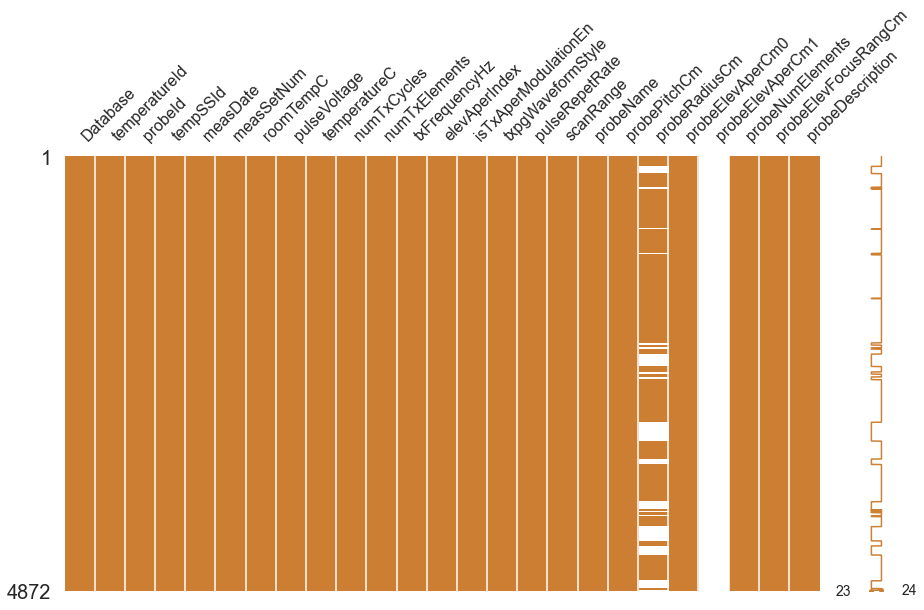

In [56]:
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(15,8), color=(0.8, 0.5, 0.2))

##### Target 데이터의 분석
- temperatureC - roomTempC 분석
- histogram이용하여 분석
- Skewneww / 왜도
    - symmetrical bell curve 혹은 normal distribution에서 왜곡 정도를 말한다. 데이터 분포의 대칭성이 얼마나 결핍되었는지를 측정한다. 완전히 대칭인 분포는 skewness가 0이다.
    - 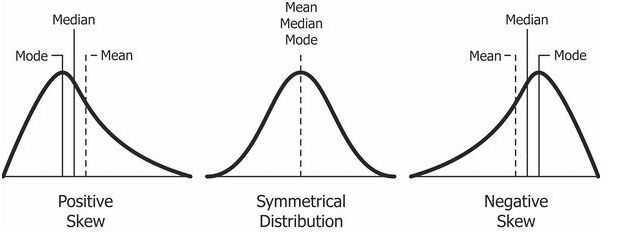

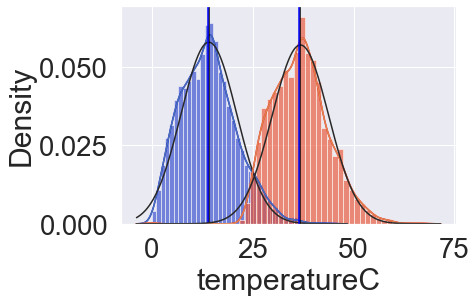

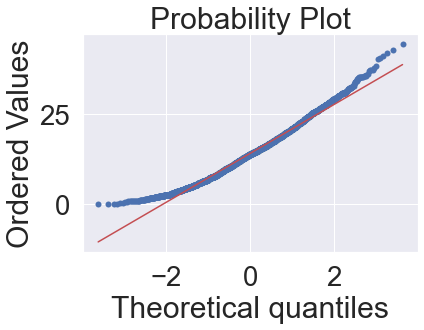

In [75]:
## histogram
TemperatureRise = (AOP_data['temperatureC'] - AOP_data['roomTempC'])
Temperature = (AOP_data['temperatureC'])

sns.distplot(TemperatureRise, color='blue')
sns.distplot(TemperatureRise, fit=norm)

plt.axvline(TemperatureRise.mean(), color='black')
plt.axvline(TemperatureRise.median(), color='blue')


sns.distplot(Temperature, color='red')
sns.distplot(Temperature, fit=norm)

plt.axvline(Temperature.mean(), color='black')
plt.axvline(Temperature.median(), color='blue')

fig = plt.figure()

res = stats.probplot(TemperatureRise, plot=plt)

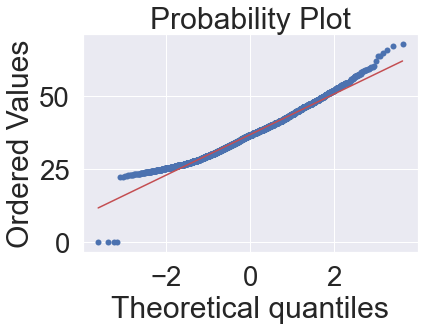

In [76]:
res = stats.probplot(Temperature, plot=plt)

In [77]:
#skewness and kurtosis
print("Skewness & TempRise: %f" % TemperatureRise.skew())
print("Kurtosis & TempRise: %f" % TemperatureRise.kurt())

print("Skewness & Temp: %f" % Temperature.skew())
print("Kurtosis & Temp: %f" % Temperature.kurt())

Skewness & TempRise: 0.476914
Kurtosis & TempRise: 0.122033
Skewness & Temp: 0.331578
Kurtosis & Temp: 0.621717


Skewness : -0.959
Kurtosis : 1.239


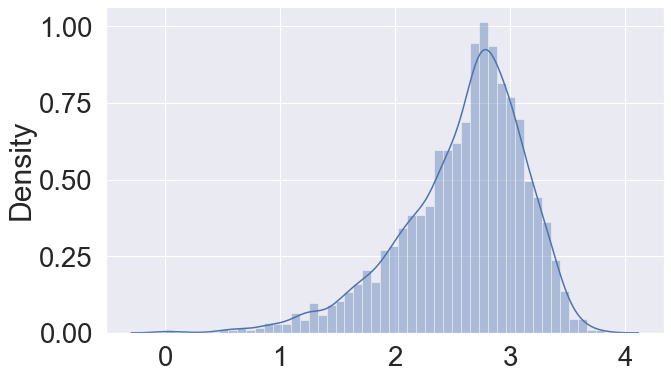

In [40]:
log_temp_rise = np.log1p(TemperatureRise)

log_skew = log_temp_rise.skew()
log_kurt = log_temp_rise.kurt()

f, ax = plt.subplots(figsize = (10, 6))
sns.distplot(log_temp_rise)

print("Skewness : {:.3f}".format(log_skew)) # 왜도
print("Kurtosis : {:.3f}".format(log_kurt)) # 첨도

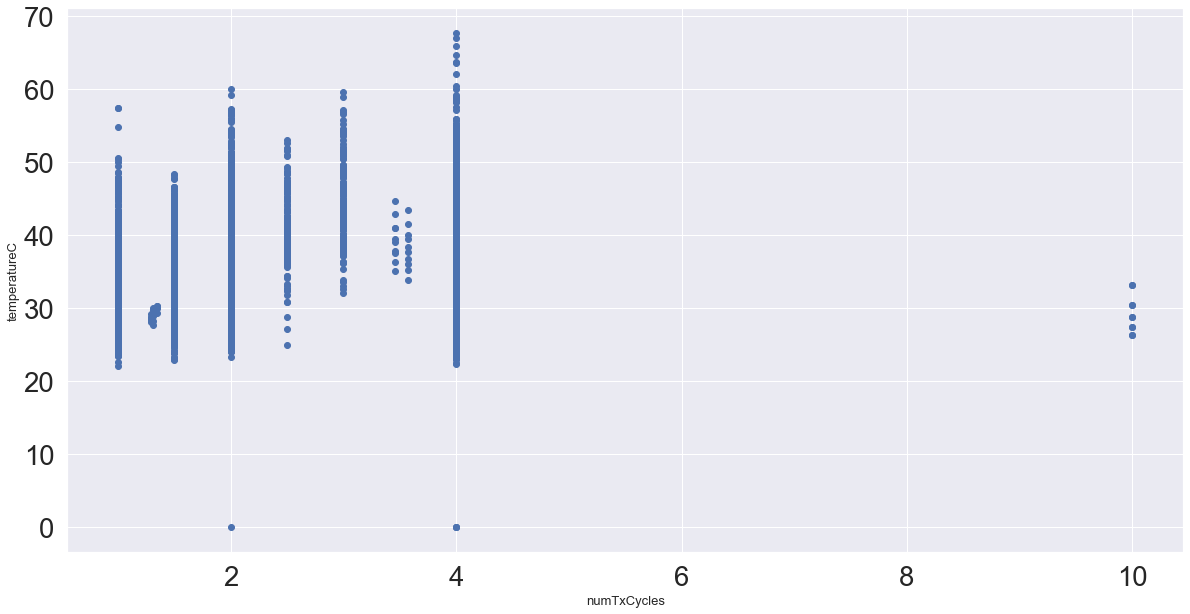

In [95]:
fig, axs = plt.subplots(figsize=(20,10))
axs.scatter(x = AOP_data['numTxCycles'], y = AOP_data['temperatureC'])
plt.xlabel('numTxCycles', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

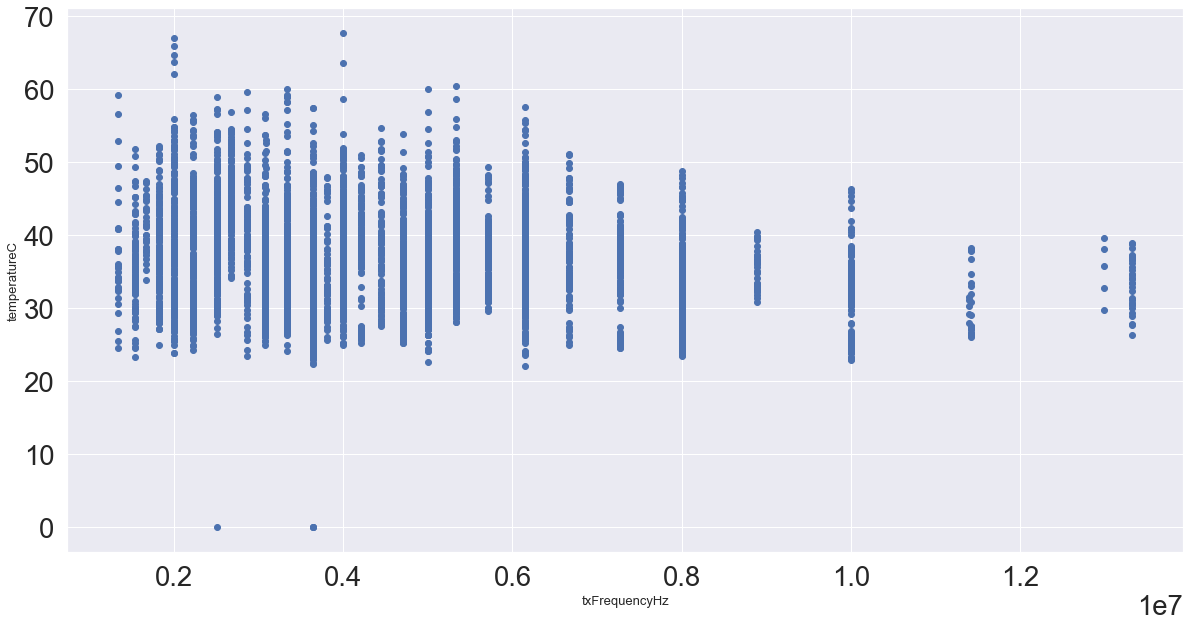

In [96]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['txFrequencyHz'], y = AOP_data['temperatureC'])
plt.xlabel('txFrequencyHz', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

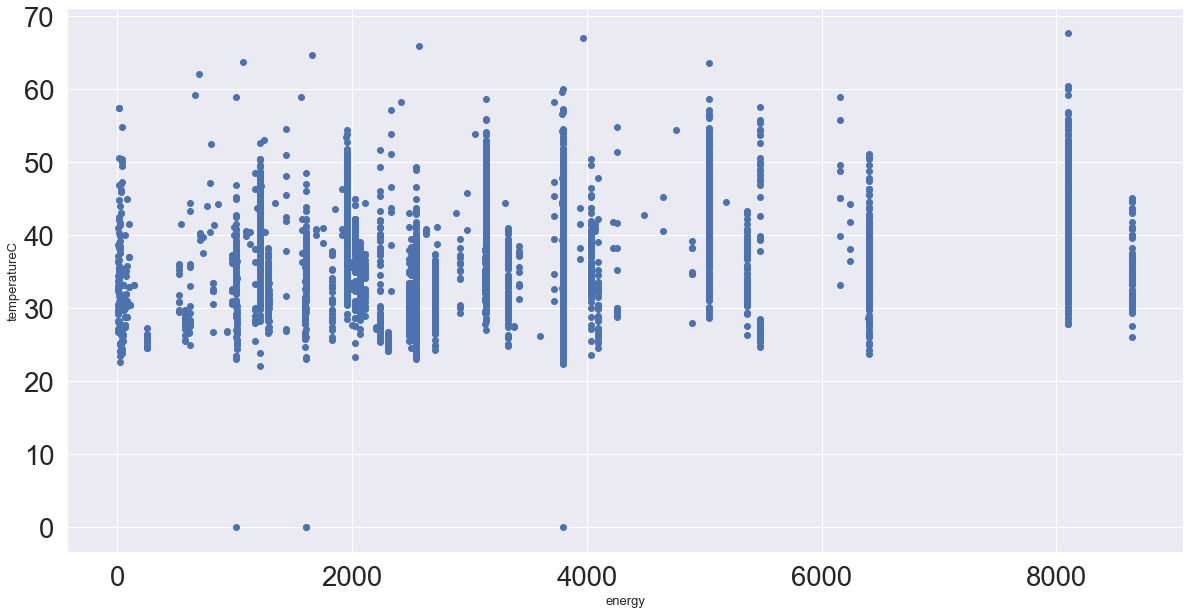

In [93]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x = AOP_data['pulseVoltage'] * AOP_data['pulseVoltage'], y = AOP_data['temperatureC'])
plt.xlabel('energy', fontsize=13)
plt.ylabel('temperatureC', fontsize=13)
plt.show()

In [14]:
if __name__ == '__main__':
    DPP = Data_Preprocess(case='model_fit')
    AOP_data = DPP._sql_get()
    ## AOP_data라는 데이터가 있을 경우, SQL에서 데이터를 읽어오지 않기  

kr001s1804srv
['Griffin_r01', 'Frosk_r03', 'New_Trees', 'LEO_4port_r01_AutoReport', 'FROSK_r01_AutoReport', 'FROSK_r02_new']
---------------
connect: Griffin_r01
Data 갯수: 2417
---------------
connect: Frosk_r03
Data 갯수: 875
---------------
connect: New_Trees
Data 갯수: 140
---------------
connect: LEO_4port_r01_AutoReport
Data 갯수: 1221
---------------
connect: FROSK_r01_AutoReport
Data 갯수: 491
---------------
connect: FROSK_r02_new
Data 갯수: 118
